# Capillary Viscometry Analysis
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2025 Monash Univ.
    @license GPL-3.0+
    @version 0.0.1
    @date 23/06/2025

    Multiphase Flow Laboratory
    Monash University, Australia




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py, os
%matplotlib widget

## Load and plot the data

In [2]:
file_name = '/Users/dduke/Desktop/e1234.h5'

data={}
H=h5py.File(file_name,'r')
for cap in H.keys():
    data[cap] = H[cap][...]
H.close()
caps = list(data.keys())

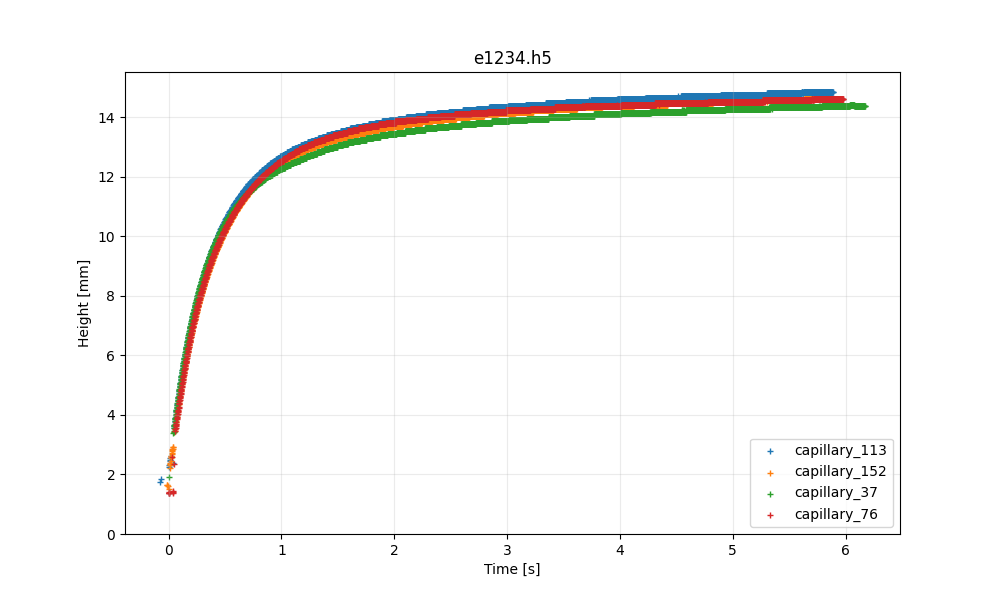

In [3]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
plt.grid(alpha=.25,which='major')
plt.grid(alpha=.25,which='minor',axis='x')
#plt.xlim(.9,8)
#plt.xscale('log')
plt.title(os.path.basename(file_name));
plt.xlabel("Time [s]")
plt.ylabel("Height [mm]")

for c in caps:
    
    time = data[c][0,:]; height = data[c][1,:]

    # Remove data points followed by a large number of NaN
    for i in range(len(time)):
        n_nan = np.sum(np.isnan(height[i:i+50]))
        if n_nan>=35: height[i]=np.nan

    # Remove data point with too large change
    flt = ~np.isnan(height)
    j = np.where(flt)[0]
    delta = np.abs(np.diff(height[flt]))
    delta = np.hstack((0,delta))
    for i in range(len(delta)):
        if delta[i] > 0.1:
            height[j[i]:j[i]+2]=np.nan

    # Shift start of curve to t=0
    time -= time[np.where(height==np.nanmin(height))[0][0]]
    
    ax.scatter(time, height, lw=1, s=15, marker='+', label=c)

plt.ylim(0,)
ax.legend();


## Estimate the initial velocity

0.997906894433214
0.9487745848136333
1.005691803699588
0.9792065539012562


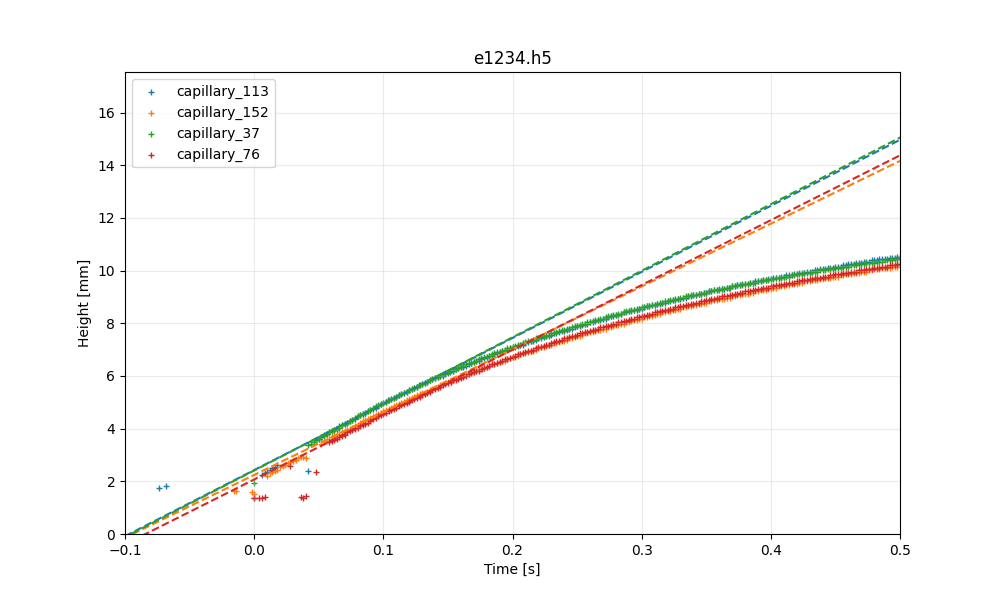

In [49]:
from scipy.optimize import curve_fit

myfun = lambda t,a,b: a*t + b

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
plt.grid(alpha=.25)
plt.title(os.path.basename(file_name));
plt.xlabel("Time [s]")
plt.ylabel("Height [mm]")

initial_velocity_estimate={}

for c in caps:
    
    time = data[c][0,:]; height = data[c][1,:]

    flt = ~np.isnan(height) & (time > .05) & (time < .15) # first fraction sec 
    
    popt,pcov=curve_fit(myfun,time[flt],height[flt],p0=[1,0])
    
    ax.scatter(time, height, lw=1, s=15, marker='+', label=c)

    plt.plot(time, myfun(time, *popt), ls='--')

    initial_velocity_estimate[c] = popt # 'a' parameter of my function, in mm/s
    print(initial_velocity_estimate[c][0]/(8*np.pi))
    
plt.ylim(0,np.nanmax(height)*1.2)
plt.xlim(-0.1,0.5)
ax.legend();


## Fit functions to the data

### The Lucas-Washburn-Rideal equation

$ \rho \pi r^2 \left( h h' \right)' = 2\pi  r \sigma \cos \theta - \pi r^2 \rho g h - 8 \pi \mu h h' $

Lumping constants, if $\theta$ is assumed constant:

$ a  \left( h h' \right)' = b - a g h - f h h'$

Apply product rule:

$ a h h'' + a h'^2  = b - a g h - f h h' = 0$

$ h'' = - \frac{h'^2}{h}  + \frac{b}{ah} - g - \frac{f h'}{a}$

Only 3 unknowns in a second-order nonlinear ODE.  $a$, $b$ depend on the geometry and $\theta$, only $f$ depends on the viscosity. The region we care most about is the early-time period where the $d$ term dominates, as $h'$ is large, but the $c$ term is small, as $h$ is small.

In [5]:
# Estimates for the constants

RHO = 1000. # kg/m3
R = 0.0005239 # m
SIGMA = 0.072 # N/m
THETA = 0 * np.pi/180. # rad
VISC = 1e-3 # Pa.s
GRAVITY = 9.81 # N/kg

If the velocity is constant in the limit $t \to 0$ with $h \approx vt + h_0$, then 

$ \frac{f h'}{a} \approx - \frac{h'^2}{h}  + \frac{b}{ah} - g $

$  f \approx - \frac{a h'}{h}  + \frac{b}{h h'} - \frac{a g}{h'} $

$  f \approx - \frac{ a v }{ h_0 } + \frac{b}{v h_0 } - \frac{ a g }{v } $

47.20352453530684
53.70293210094555
46.69640682086993
52.68316678228881


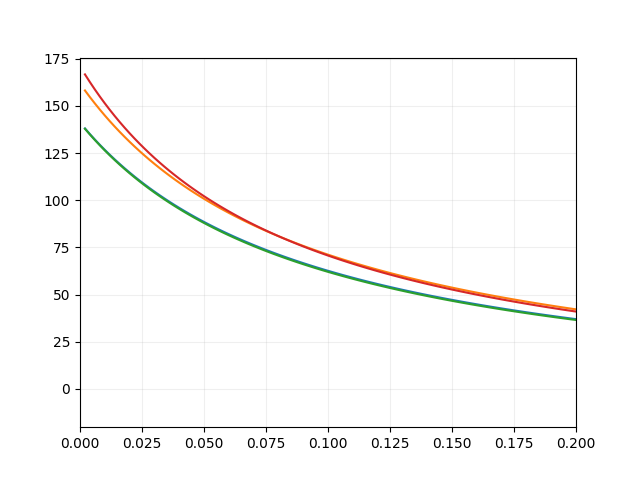

In [59]:
a = RHO * np.pi * R**2
b = 2*np.pi*R*SIGMA*np.cos(THETA)

fig=plt.figure()
plt.grid(alpha=.2)

for c in caps:
    
    h0 = initial_velocity_estimate[c][1] * 1e-3
    v0 = initial_velocity_estimate[c][0] * 1e-3
    
    
    h = h0+v0*.15
    f = (-a*v0/h) + (b/(v0*h)) - (a*GRAVITY)/v0
    print(1e3*f/(8*np.pi))
    
    plt.plot(time[time>0], ((-a*v0/(h0+v0*time[time>0])) + (b/(v0*(h0+v0*time[time>0]))) - (a*GRAVITY)/v0)*1e3/(8*np.pi))

#plt.ylim(-10,100);
plt.xlim(0,.2);

## Attempt to fit the full LWR equation

In [91]:
import lmfit
from lmfit import Parameters, minimize, report_fit
from scipy.integrate import odeint

def lwr_system(y, t, params):
    # Unpack parameters from lmfit.Parameters object
    r_ = params['r'].value
    rho_ = params['rho'].value
    sigmat_ = params['sigmat'].value
    visc_ = params['visc'].value
    h0_ = params['h0'].value

    a = rho_ * np.pi * r_**2
    b = 2*np.pi*r_*sigmat_
    f = 8*np.pi*visc_
    
    # y = [ h h' ] ; y' = [ h' h'' ]
    # Define the differential equations
    dydt = [  y[1], 
            (-y[1]**2/(y[0]-h0_))+(b/(a*(y[0]-h0_)))-GRAVITY-(f*y[1])/a ]
    
    return dydt

def simulate_ode(t, initial_conditions, params):
    solution = odeint(lwr_system, initial_conditions, t, args=(params,))
    return solution

def residual(params, t, data, initial_conditions):
    model = simulate_ode(t, initial_conditions, params)
    res = (model - data)
    res[:,1]=0#res[:,0] # do not check residuals on velocity, only height
    return res.ravel()  # Flatten for lmfit

params = Parameters()
params.add('r',     value=R,                   min=R*0.95, max=R*1.05)
params.add('rho',   value=RHO,                 min=RHO*0.85, max=RHO*1.5)
params.add('sigmat',value=SIGMA*np.cos(THETA), min=SIGMA*0.5, max=SIGMA*2)
params.add('h0',    value=0,                   min=-1, max=1)
params.add('visc',  value=VISC,                min=0.1*VISC, max=100*VISC)

# use non-NaN data when t>~0
flt = ~np.isnan(data[caps[0]][1,:]) & (data[caps[0]][0,:]>=0.01) 
# use early time data
flt = flt & (data[caps[0]][0,:] < 2.0 )

c= caps[0]
model_time = data[c][0,flt] # seconds
height = data[c][1,flt] * 1e-3 # convert to m
initial_dhdt = initial_velocity_estimate[c][0] * 1e-3 # convert to m/s

initial_conditions=[height[0], initial_dhdt]
print(initial_conditions)

expt_data=np.vstack((height,height)).transpose()

[np.float64(0.00235), np.float64(0.025080135748143925)]


In [92]:
result = minimize(residual, params, args=(model_time, expt_data, initial_conditions), method='leastsq')
report_fit(result)

print("----")
print("VISC=%g mPa.s" % (1e3*result.params['visc'].value))
print("RHO =%g kg/m3" % (result.params['rho'].value))
print("R   =%g um" % (result.params['r'].value*1e6))
print("SIGMA.cos(THETA)=%g mN/m" % (1e3*result.params['sigmat'].value ))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 212
    # data points      = 1964
    # variables        = 5
    chi-square         = 2.9665e-06
    reduced chi-square = 1.5143e-09
    Akaike info crit   = -39880.5704
    Bayesian info crit = -39852.6567
[[Variables]]
    r:       5.1719e-04 +/- 6.0440e-05 (11.69%) (init = 0.0005239)
    rho:     1499.45053 +/- 29.1749978 (1.95%) (init = 1000)
    sigmat:  0.09405224 +/- 0.00940079 (10.00%) (init = 0.072)
    h0:     -0.01064875 +/- 5.8034e-05 (0.54%) (init = 0)
    visc:    0.01150206 +/- 0.00247637 (21.53%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(r, visc)      = +0.9998
    C(sigmat, visc) = +0.9980
    C(r, sigmat)    = +0.9973
    C(r, rho)       = -0.9504
    C(rho, visc)    = -0.9452
    C(rho, sigmat)  = -0.9257
    C(sigmat, h0)   = -0.3025
    C(r, h0)        = -0.2488
    C(h0, visc)     = -0.2484
----
VISC=11.5021 mPa.s
RHO =1499.45 kg/m3
R   =517.187 um
SIGMA.

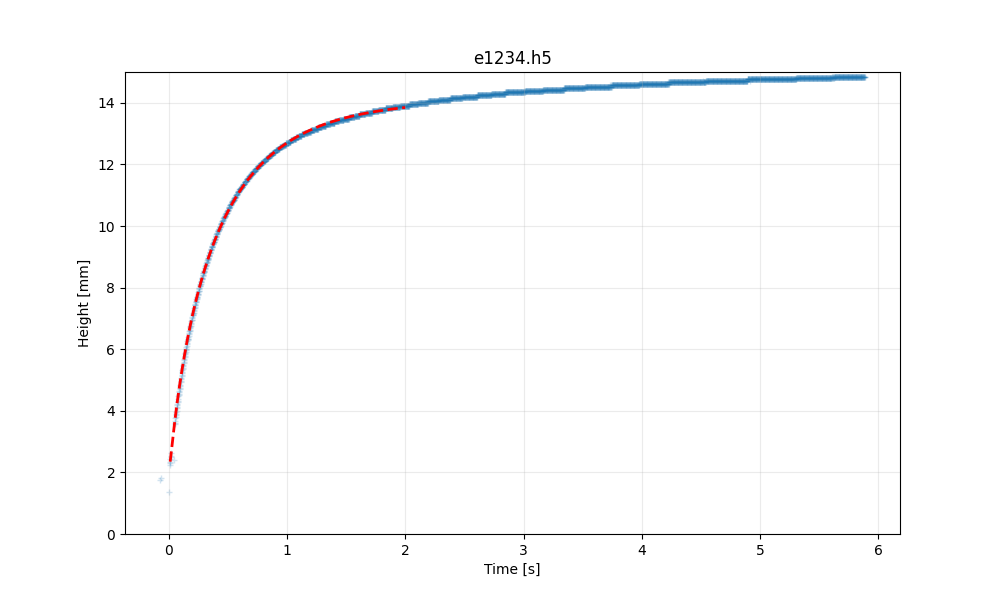

In [93]:
fig=plt.figure(figsize=(10,6))

ax=fig.add_subplot(111)
plt.grid(alpha=.25,which='major')
plt.grid(alpha=.25,which='minor',axis='x')
#plt.xlim(-0.1,1.5)
plt.ylim(0,15)
#plt.yscale('log'); plt.ylim(1,20)
plt.title(os.path.basename(file_name));
plt.xlabel("Time [s]")
plt.ylabel("Height [mm]")

#ax2=ax.twinx()

for c in caps:
    time = data[c][0,:]
    ax.scatter(time, data[c][1,:], lw=1, s=15, marker='+', alpha=.2)

    model = simulate_ode(model_time, initial_conditions, result.params)
    
    ax.plot(model_time, 1e3*model[:,0] , lw=2, c='r', ls='--') # back from m to mm

    break

#ax.legend();